Percentage of missing values in each feature:
Id                                      0.00
date                                    0.00
Lagging_Current_Reactive.Power_kVarh    0.00
Leading_Current_Reactive_Power_kVarh    0.43
CO2(tCO2)                               0.00
Lagging_Current_Power_Factor            0.00
Leading_Current_Power_Factor            0.27
NSM                                     0.00
WeekStatus                              6.34
Day_of_week                             6.34
Load_Type                               0.00
Usage_kWh                               0.00
dtype: float64
Number of outliers removed: 867
Average RMSE score: 2.1957957688954735
Average MAE score: 1.3017615438529604
Average R-squared score: 0.995100072983567


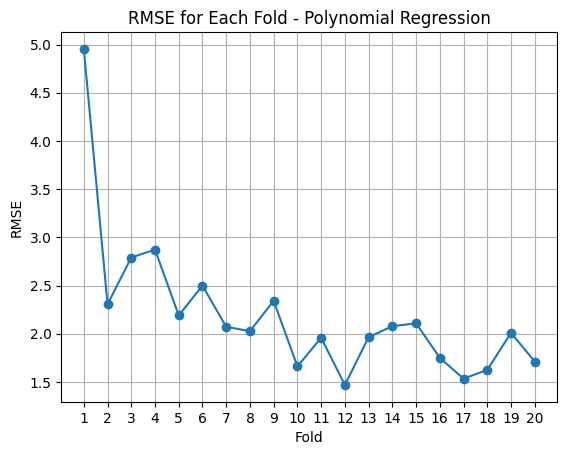

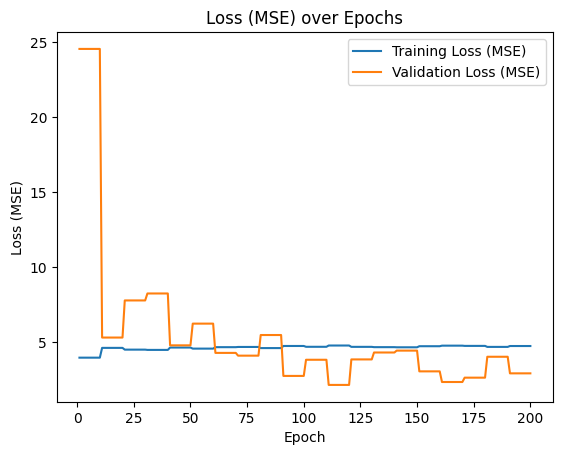

In [6]:
# Polynomial Regression with KFold only
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Fixing the date
df = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df2['date'] = pd.to_datetime(df2['date'], format='%d/%m/%Y %H:%M')

percentage_missing_values = (df.isnull().mean() * 100).round(2)
print("Percentage of missing values in each feature:")
print(percentage_missing_values)

# Imputing numerical values
impute_columns = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                  'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[impute_columns] = imputer.fit_transform(df[impute_columns])
df2[impute_columns] = imputer.transform(df2[impute_columns])

# Imputing categorical values
impute_columns = ['WeekStatus', 'Day_of_week', 'Load_Type']
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[impute_columns] = imputer.fit_transform(df[impute_columns])
df2[impute_columns] = imputer.transform(df2[impute_columns])


# Detecting outliers and removing them
num_cols = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
            'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'Usage_kWh']

z_scores = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std()
num_outliers = ((z_scores < -3) | (z_scores > 3)).sum().sum()
df = df[~((z_scores < -3) | (z_scores > 3)).any(axis=1)]
print(f"Number of outliers removed: {num_outliers}")

df['Lagging_Current_Reactive.Power_kVarh'] *= 0.000277778
df['Leading_Current_Reactive_Power_kVarh'] *= 0.000277778
df2['Lagging_Current_Reactive.Power_kVarh'] *= 0.000277778
df2['Leading_Current_Reactive_Power_kVarh'] *= 0.000277778

# Encoding categorical variables
ohe = OneHotEncoder()
categorical_cols = ['WeekStatus', 'Day_of_week', 'Load_Type']
for col in categorical_cols:
    df_ohe = pd.DataFrame(ohe.fit_transform(df[[col]]).toarray(), columns=ohe.categories_[0])
    df = df.drop(col, axis=1).merge(df_ohe, left_index=True, right_index=True)
    df2_ohe = pd.DataFrame(ohe.transform(df2[[col]]).toarray(), columns=ohe.categories_[0])
    df2 = df2.drop(col, axis=1).merge(df2_ohe, left_index=True, right_index=True)

# Scaling numerical columns
scaler = StandardScaler()
num_cols = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
            'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
df[num_cols] = scaler.fit_transform(df[num_cols])
df2[num_cols] = scaler.transform(df2[num_cols])

# Define the features and target variable
features = df.drop(['date', 'Id', 'Usage_kWh'], axis=1)
target = df['Usage_kWh']

# Initialize KFold with 20 folds
kf = KFold(n_splits=20)

# Define the pipeline with Polynomial Regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),  # Adjust the degree as needed
    ('regressor', LinearRegression())
])

# Initialize empty lists to store the evaluation metrics and fold-wise RMSE
rmse_scores, mae_scores, r2_scores = [], [], []
fold_indices, fold_rmse = [], []
train_losses = []
val_losses = []

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(features), 1):
    # Split the data into training and testing sets
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    num_epochs = 10

    # Training loop over epochs
    for epoch in range(num_epochs):
        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        # Predictions for training and validation sets
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        # Calculate mean squared error for training and validation sets
        train_loss = mean_squared_error(y_train, y_train_pred)
        val_loss = mean_squared_error(y_test, y_test_pred)

        # Append the loss for current epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    # Predict the target variable for the test data
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_score = mean_absolute_error(y_test, y_pred)
    r2_eval_score = r2_score(y_test, y_pred)

    # Append the evaluation metrics to the lists
    rmse_scores.append(rmse_score)
    mae_scores.append(mae_score)
    r2_scores.append(r2_eval_score)

    # Append fold index and RMSE for the current fold
    fold_indices.append(fold)
    fold_rmse.append(rmse_score)

# Compute the average evaluation metric across all folds
avg_rmse_score = np.mean(rmse_scores)
avg_mae_score = np.mean(mae_scores)
avg_r2_score = np.mean(r2_scores)

print(f"Average RMSE score: {avg_rmse_score}")
print(f"Average MAE score: {avg_mae_score}")
print(f"Average R-squared score: {avg_r2_score}")

# Plotting RMSE for each fold
plt.plot(fold_indices, fold_rmse, marker='o', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE for Each Fold - Polynomial Regression')
plt.xticks(np.arange(1, kf.get_n_splits() + 1))
plt.grid(True)
plt.show()
plt.plot(range(1, num_epochs * kf.get_n_splits() + 1), train_losses, label='Training Loss (MSE)')
plt.plot(range(1, num_epochs * kf.get_n_splits() + 1), val_losses, label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) over Epochs')
plt.legend()
plt.show()




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Percentage of missing values in each feature:
Id                                      0.0
date                                    0.0
Lagging_Current_Reactive.Power_kVarh    0.0
Leading_Current_Reactive_Power_kVarh    0.0
CO2(tCO2)                               0.0
Lagging_Current_Power_Factor            0.0
Leading_Current_Power_Factor            0.0
NSM                                     0.0
Usage_kWh                               0.0
Weekday                                 0.0
Weekend                                 0.0
Friday                                  0.0
Monday                                  0.0
Saturday                                0.0
Sunday                                  0.0
Thursday                                0.0
Tuesday                                 0.0
Wednesday                               0.0
Light_Load                              0.0
Maximum_Load                            0.0
Medium_Load                             0.0
dtype: float64
Average RMSE sc

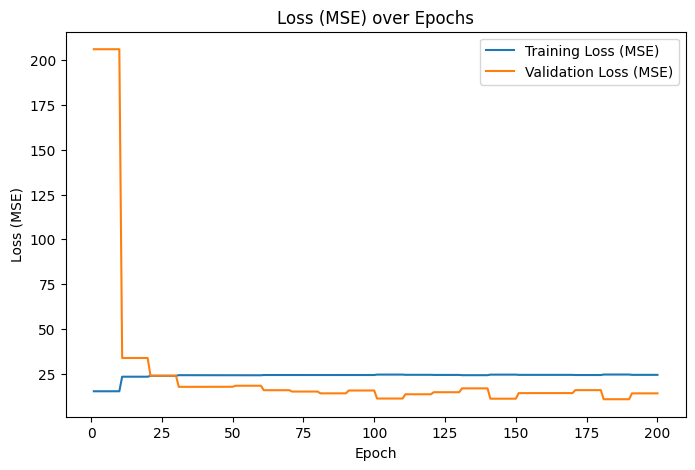

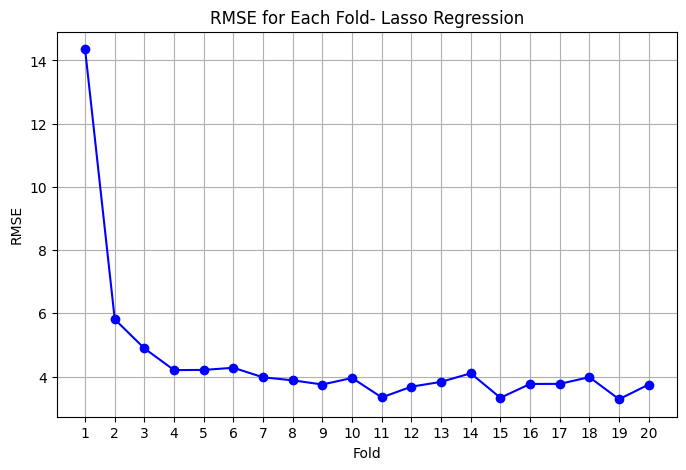

In [26]:
#Lasso Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

# Load data
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')

percentage_missing_values = (df.isnull().mean() * 100).round(2)
print("Percentage of missing values in each feature:")
print(percentage_missing_values)

# Fixing the date
df_train['date'] = pd.to_datetime(df_train['date'], format='%d/%m/%Y %H:%M')
df_test['date'] = pd.to_datetime(df_test['date'], format='%d/%m/%Y %H:%M')

def extract_date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    return df

# Fixing the date
df_train = extract_date_features(df_train)
df_test = extract_date_features(df_test)

# Define numerical and categorical features
numeric_features = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
                    'year', 'month', 'day', 'hour', 'minute']
categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Apply preprocessing steps to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Pass through the remaining columns as they are
)

# Initialize KFold with 15 folds
kf = KFold(n_splits=20)
alpha = 0.01  # Regularization strength

# Initialize empty lists to store the evaluation metrics
rmse_scores, mae_scores, r2_scores = [], [], []

train_losses = []
val_losses = []

# Initialize empty lists to store fold indices and fold-wise RMSE
fold_indices, fold_rmse = [], []

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(df_train), 1):
    # Initialize the Lasso regression model
    lasso_model = Lasso(alpha=alpha)

    # Initialize feature selection based on Lasso regression
    feature_selection = SelectFromModel(lasso_model)

    # Modify the pipeline to include feature selection
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selection),  # Add feature selection step
        ('lasso', lasso_model)
    ])

    # Split the data into training and testing sets for this fold
    X_train, X_test = df_train.iloc[train_index], df_train.iloc[test_index]
    y_train, y_test = df_train['Usage_kWh'].iloc[train_index], df_train['Usage_kWh'].iloc[test_index]

    num_epochs = 10

    # Training loop over epochs
    for epoch in range(num_epochs):
        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        # Predictions for training and validation sets
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        # Calculate mean squared error for training and validation sets
        train_loss = mean_squared_error(y_train, y_train_pred)
        val_loss = mean_squared_error(y_test, y_test_pred)

        # Append the loss for current epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Predict the target variable for the test data
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_score = mean_absolute_error(y_test, y_pred)
    rtwo_score = r2_score(y_test, y_pred)

    # Append the evaluation metrics to the lists
    rmse_scores.append(rmse_score)
    mae_scores.append(mae_score)
    r2_scores.append(rtwo_score)

    # Append fold index and RMSE for the current fold
    fold_indices.append(fold)
    fold_rmse.append(rmse_score)

# Compute the average evaluation metric across all folds
avg_rmse_score = np.mean(rmse_scores)
avg_mae_score = np.mean(mae_scores)
avg_r2_score = np.mean(r2_scores)

print(f"Average RMSE score: {avg_rmse_score}")
print(f"Average MAE score: {avg_mae_score}")
print(f"Average R-squared score: {avg_r2_score}")

# Plotting the first graph for Loss (MSE) over Epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs * kf.get_n_splits() + 1), train_losses, label='Training Loss (MSE)')
plt.plot(range(1, num_epochs * kf.get_n_splits() + 1), val_losses, label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) over Epochs')
plt.legend()
plt.show()

# Plotting the second graph for RMSE for Each Fold
plt.figure(figsize=(8, 5))
plt.plot(fold_indices, fold_rmse, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE for Each Fold- Lasso Regression')
plt.xticks(np.arange(1, kf.get_n_splits() + 1))
plt.grid(True)
plt.show()

X_test = df_test.drop(columns=['date', 'Id'])

# Make predictions
predictions = pipeline.predict(X_test)

# Create submission DataFrame
#submission = pd.DataFrame({'Id': df_test['Id'], 'Usage_kWh': predictions})

# Save submission DataFrame to CSV
#submission.to_csv('Lassosubmission.csv', index=False)

# Display success message
#print("Submission file saved successfully.")


Percentage of missing values in each feature:
Id                                      0.00
date                                    0.00
Lagging_Current_Reactive.Power_kVarh    0.00
Leading_Current_Reactive_Power_kVarh    0.43
CO2(tCO2)                               0.00
Lagging_Current_Power_Factor            0.00
Leading_Current_Power_Factor            0.27
NSM                                     0.00
WeekStatus                              6.34
Day_of_week                             6.34
Load_Type                               0.00
Usage_kWh                               0.00
dtype: float64
Number of outliers removed: 867
Average RMSE score: 4.397558804428701


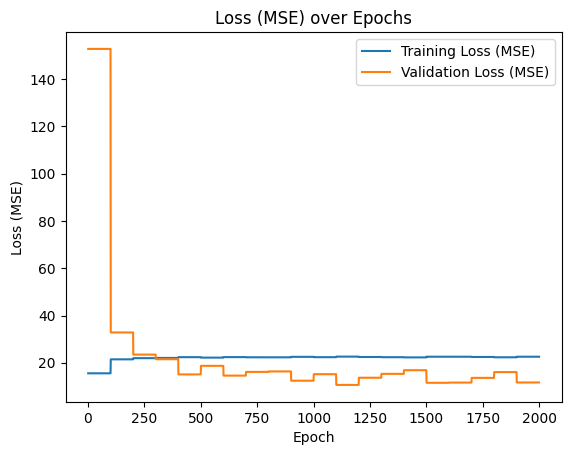

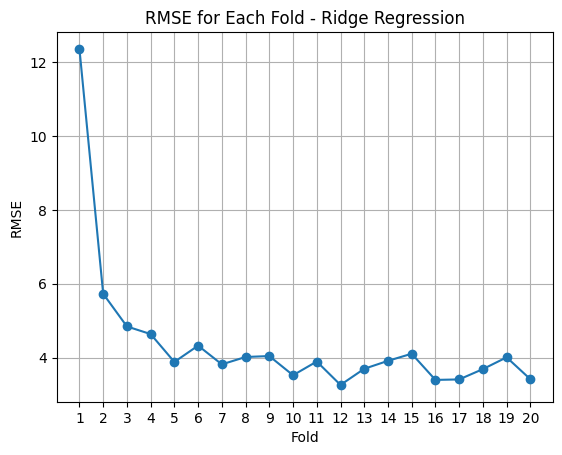

In [4]:
#Ridge With K-fold only
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Fixing the date
df = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')
percentage_missing_values = (df.isnull().mean() * 100).round(2)
print("Percentage of missing values in each feature:")
print(percentage_missing_values)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df2['date'] = pd.to_datetime(df2['date'], format='%d/%m/%Y %H:%M')

# Imputing numerical values
impute_columns = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                  'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[impute_columns] = imputer.fit_transform(df[impute_columns])
df2[impute_columns] = imputer.transform(df2[impute_columns])

# Imputing categorical values
impute_columns = ['WeekStatus', 'Day_of_week', 'Load_Type']
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[impute_columns] = imputer.fit_transform(df[impute_columns])
df2[impute_columns] = imputer.transform(df2[impute_columns])

# Detecting outliers and removing them
num_cols = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
            'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'Usage_kWh']

z_scores = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std()
num_outliers = ((z_scores < -3) | (z_scores > 3)).sum().sum()
df = df[~((z_scores < -3) | (z_scores > 3)).any(axis=1)]
print(f"Number of outliers removed: {num_outliers}")

df['Lagging_Current_Reactive.Power_kVarh'] *= 0.000277778
df['Leading_Current_Reactive_Power_kVarh'] *= 0.000277778
df2['Lagging_Current_Reactive.Power_kVarh'] *= 0.000277778
df2['Leading_Current_Reactive_Power_kVarh'] *= 0.000277778

# Encoding categorical variables
ohe = OneHotEncoder()
categorical_cols = ['WeekStatus', 'Day_of_week', 'Load_Type']
for col in categorical_cols:
    df_ohe = pd.DataFrame(ohe.fit_transform(df[[col]]).toarray(), columns=ohe.categories_[0])
    df = df.drop(col, axis=1).merge(df_ohe, left_index=True, right_index=True)
    df2_ohe = pd.DataFrame(ohe.transform(df2[[col]]).toarray(), columns=ohe.categories_[0])
    df2 = df2.drop(col, axis=1).merge(df2_ohe, left_index=True, right_index=True)

# Scaling numerical columns
scaler = StandardScaler()
num_cols = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
            'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
df[num_cols] = scaler.fit_transform(df[num_cols])
df2[num_cols] = scaler.transform(df2[num_cols])

# Define the features and target variable
features = df.drop(['date', 'Id', 'Usage_kWh'], axis=1)
target = df['Usage_kWh']

# Initialize KFold with 5 folds
kf = KFold(n_splits=20)
alpha = 0.01  # Regularization strength

# Define the feature names
feature_names = features.columns.tolist()

# Initialize empty lists to store the evaluation metrics and fold-wise RMSE
rmse_scores, fold_indices, fold_rmse = [], [], []
train_losses = []
val_losses = []

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(features), 1):
    # Split the data into training and testing sets
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Initialize the Ridge regression model
    ridge = Ridge(alpha=alpha)

    # Number of epochs
    num_epochs = 100

    # Training loop over epochs
    for epoch in range(num_epochs):
        # Fit the model
        ridge.fit(X_train, y_train)

        # Predictions for training and validation sets
        y_train_pred = ridge.predict(X_train)
        y_test_pred = ridge.predict(X_test)

        # Calculate mean squared error for training and validation sets
        train_loss = mean_squared_error(y_train, y_train_pred)
        val_loss = mean_squared_error(y_test, y_test_pred)

        # Append the loss for current epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Predict the target variable for the test data
    y_pred = ridge.predict(X_test)

    # Calculate evaluation metrics
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))

    # Append the RMSE for the current fold
    rmse_scores.append(rmse_score)

    # Append fold index and RMSE for the current fold
    fold_indices.append(fold)
    fold_rmse.append(rmse_score)

# Compute the average RMSE score across all folds
avg_rmse_score = np.mean(rmse_scores)

print(f"Average RMSE score: {avg_rmse_score}")

# Plot the loss function (MSE) over epochs
plt.plot(range(1, num_epochs * kf.get_n_splits() + 1), train_losses, label='Training Loss (MSE)')
plt.plot(range(1, num_epochs * kf.get_n_splits() + 1), val_losses, label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) over Epochs')
plt.legend()
plt.show()

# Plotting RMSE for each fold
plt.plot(fold_indices, fold_rmse, marker='o', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE for Each Fold - Ridge Regression')
plt.xticks(np.arange(1, kf.get_n_splits() + 1))
plt.grid(True)
plt.show()


In [3]:
#Ridge Regression with kfold and hyperparameter(random search) and kfold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from scipy.stats import uniform

# Load data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


percentage_missing_values = (df.isnull().mean() * 100).round(2)
print("Percentage of missing values in each feature:")
print(percentage_missing_values)

# Fixing the date
df_train['date'] = pd.to_datetime(df_train['date'], format='%d/%m/%Y %H:%M')
df_test['date'] = pd.to_datetime(df_test['date'], format='%d/%m/%Y %H:%M')

# Define numerical and categorical features
numeric_features = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Apply preprocessing steps to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define model and pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())])

# Define hyperparameters for random search
param_dist = {
    'regressor__alpha': uniform(0.001, 10)
}

# Initialize RandomizedSearchCV

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Split data into features and target
X_train = df_train.drop(columns=['date', 'Id', 'Usage_kWh'])
y_train = df_train['Usage_kWh']

# Perform random search
random_search.fit(X_train, y_train)

# Print best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Get best model from random search
best_model = random_search.best_estimator_

# Train best model on entire training data
best_model.fit(X_train, y_train)

# Make predictions on training set
y_train_pred = best_model.predict(X_train)

# Calculate evaluation metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Print evaluation metrics
print("Training RMSE:", rmse_train)
print("Training MAE:", mae_train)
print("Training R-squared:", r2_train)

# Make predictions on test data
X_test = df_test.drop(columns=['date', 'Id'])
predictions = best_model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({'Id': df_test['Id'], 'Usage_kWh': predictions})

# Save submission DataFrame to CSV
submission.to_csv('submission_Ridge2.csv', index=False)

# Display success message
print("Submission file saved successfully.")


Percentage of missing values in each feature:
Id                                      0.0
date                                    0.0
Lagging_Current_Reactive.Power_kVarh    0.0
Leading_Current_Reactive_Power_kVarh    0.0
CO2(tCO2)                               0.0
Lagging_Current_Power_Factor            0.0
Leading_Current_Power_Factor            0.0
NSM                                     0.0
Usage_kWh                               0.0
Weekday                                 0.0
Weekend                                 0.0
Friday                                  0.0
Monday                                  0.0
Saturday                                0.0
Sunday                                  0.0
Thursday                                0.0
Tuesday                                 0.0
Wednesday                               0.0
Light_Load                              0.0
Maximum_Load                            0.0
Medium_Load                             0.0
dtype: float64
Fitting 5 folds

Percentage of missing values in each feature:
Id                                      0.00
date                                    0.00
Lagging_Current_Reactive.Power_kVarh    0.00
Leading_Current_Reactive_Power_kVarh    0.43
CO2(tCO2)                               0.00
Lagging_Current_Power_Factor            0.00
Leading_Current_Power_Factor            0.27
NSM                                     0.00
WeekStatus                              6.34
Day_of_week                             6.34
Load_Type                               0.00
Usage_kWh                               0.00
dtype: float64
Number of outliers removed: 867
Average RMSE score: 4.3980289767984715
Average MAE score: 2.6355404716796538
Average R-squared score: 0.979742543186347


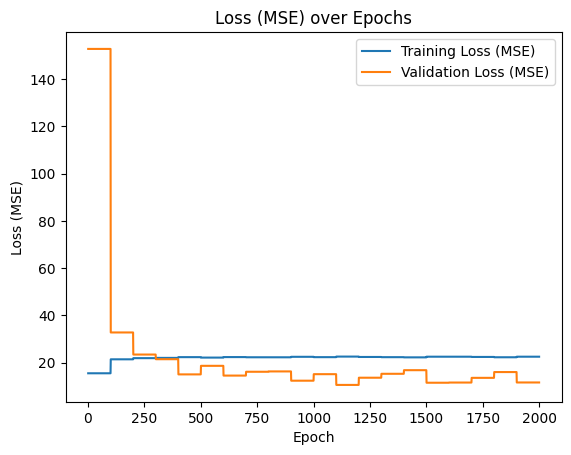

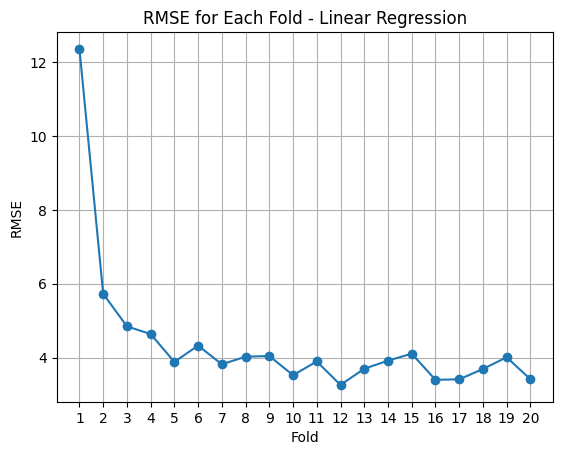

In [2]:
#Linear Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Fixing the date
df = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df2['date'] = pd.to_datetime(df2['date'], format='%d/%m/%Y %H:%M')

percentage_missing_values = (df.isnull().mean() * 100).round(2)
print("Percentage of missing values in each feature:")
print(percentage_missing_values)
# Imputing numerical values
impute_columns = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                  'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[impute_columns] = imputer.fit_transform(df[impute_columns])
df2[impute_columns] = imputer.transform(df2[impute_columns])

# Imputing categorical values
impute_columns = ['WeekStatus', 'Day_of_week', 'Load_Type']
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[impute_columns] = imputer.fit_transform(df[impute_columns])
df2[impute_columns] = imputer.transform(df2[impute_columns])

# Detecting outliers and removing them
num_cols = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
            'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'Usage_kWh']

z_scores = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std()
num_outliers = ((z_scores < -3) | (z_scores > 3)).sum().sum()
df = df[~((z_scores < -3) | (z_scores > 3)).any(axis=1)]
print(f"Number of outliers removed: {num_outliers}")

# Encoding categorical variables
ohe = OneHotEncoder()
categorical_cols = ['WeekStatus', 'Day_of_week', 'Load_Type']
for col in categorical_cols:
    df_ohe = pd.DataFrame(ohe.fit_transform(df[[col]]).toarray(), columns=ohe.categories_[0])
    df = df.drop(col, axis=1).merge(df_ohe, left_index=True, right_index=True)
    df2_ohe = pd.DataFrame(ohe.transform(df2[[col]]).toarray(), columns=ohe.categories_[0])
    df2 = df2.drop(col, axis=1).merge(df2_ohe, left_index=True, right_index=True)

# Scaling numerical columns
scaler = StandardScaler()
num_cols = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
            'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
df[num_cols] = scaler.fit_transform(df[num_cols])
df2[num_cols] = scaler.transform(df2[num_cols])

# Define the features and target variable
features = df.drop(['date', 'Id', 'Usage_kWh'], axis=1)
target = df['Usage_kWh']

# Initialize KFold with 20 folds
kf = KFold(n_splits=20)

# Define the pipeline with Linear Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Initialize empty lists to store the evaluation metrics
rmse_scores, mae_scores, r2_scores = [], [], []

train_losses = []
val_losses = []

# Loop through each fold
for train_index, test_index in kf.split(features):
    # Split the data into training and testing sets
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Number of epochs
    num_epochs = 100

    # Training loop over epochs
    for epoch in range(num_epochs):
        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        # Predictions for training and validation sets
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        # Calculate mean squared error for training and validation sets
        train_loss = mean_squared_error(y_train, y_train_pred)
        val_loss = mean_squared_error(y_test, y_test_pred)

        # Append the loss for current epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Predict the target variable for the test data
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_score = mean_absolute_error(y_test, y_pred)
    r2_eval_score = r2_score(y_test, y_pred)

    # Append the evaluation metrics to the lists
    rmse_scores.append(rmse_score)
    mae_scores.append(mae_score)
    r2_scores.append(r2_eval_score)

# Compute the average evaluation metric across all folds
avg_rmse_score = np.mean(rmse_scores)
avg_mae_score = np.mean(mae_scores)
avg_r2_score = np.mean(r2_scores)

print(f"Average RMSE score: {avg_rmse_score}")
print(f"Average MAE score: {avg_mae_score}")
print(f"Average R-squared score: {avg_r2_score}")

plt.plot(range(1, num_epochs * kf.get_n_splits() + 1), train_losses, label='Training Loss (MSE)')
plt.plot(range(1, num_epochs * kf.get_n_splits() + 1), val_losses, label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) over Epochs')
plt.legend()
plt.show()

# Plotting RMSE for each fold
plt.plot(range(1, kf.get_n_splits() + 1), rmse_scores, marker='o', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE for Each Fold - Linear Regression')
plt.xticks(np.arange(1, kf.get_n_splits() + 1))
plt.grid(True)
plt.show()


In [ ]:
#SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer

# Load data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Fixing the date
df_train['date'] = pd.to_datetime(df_train['date'], format='%d/%m/%Y %H:%M')
df_test['date'] = pd.to_datetime(df_test['date'], format='%d/%m/%Y %H:%M')

# Define numerical and categorical features
numeric_features = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Apply preprocessing steps to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model and pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Split data into features and target
X_train = df_train.drop(columns=['date', 'Id', 'Usage_kWh'])
y_train = df_train['Usage_kWh']

# Split the data into train and test sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train_split, y_train_split)

# Make predictions on test data
y_pred = pipeline.predict(X_test_split)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
mae = mean_absolute_error(y_test_split, y_pred)
r2 = r2_score(y_test_split, y_pred)

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared score:", r2)

# Make predictions on the actual test data
predictions = pipeline.predict(df_test.drop(columns=['date', 'Id']))

# Create submission DataFrame
submission = pd.DataFrame({'Id': df_test['Id'], 'Usage_kWh': predictions})

# Save submission DataFrame to CSV
submission.to_csv('submission_svr.csv', index=False)

# Display success message
print("Submission file saved successfully.")


Root Mean Squared Error (RMSE): 2.8933889701347772
Mean Absolute Error (MAE): 1.3305148577247432
R-squared score: 0.9927460634398925
Submission file saved successfully.


In [ ]:
#SVR with Kfold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer

# Load data
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')

df_train['date'] = pd.to_datetime(df_train['date'], format='%d/%m/%Y %H:%M')
df_test['date'] = pd.to_datetime(df_test['date'], format='%d/%m/%Y %H:%M')

def extract_date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    return df

# Fixing the date
df_train = extract_date_features(df_train)
df_test = extract_date_features(df_test)
# Define numerical and categorical features
umeric_features = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
                    'year', 'month', 'day', 'hour', 'minute']
categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']


# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Apply preprocessing steps to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Pass through the remaining columns as they are
)

# Define the model
model = SVR()

# Initialize k-fold cross-validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store data splits
X_train_list, X_val_list, X_test_list = [], [], []
y_train_list, y_val_list, y_test_list = [], [], []

# Perform k-fold cross-validation to split data into train, validation, and test sets
for fold_idx, (train_idx, test_idx) in enumerate(k_fold.split(df_train)):
    print(f"Fold {fold_idx + 1}:")
    print("Train indices:", train_idx)
    print("Test indices:", test_idx)

    train_data = df_train.iloc[train_idx]
    test_data = df_train.iloc[test_idx]

    # Split train data further into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['date', 'Id', 'Usage_kWh']),
                                                      train_data['Usage_kWh'], test_size=0.2, random_state=42)
    X_test = test_data.drop(columns=['date', 'Id', 'Usage_kWh'])
    y_test = test_data['Usage_kWh']

    X_train_list.append(X_train)
    X_val_list.append(X_val)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_val_list.append(y_val)
    y_test_list.append(y_test)

    # Remove this break to iterate through all folds
    break  # Remove this break after debugging

# Define a function to concatenate lists of splits into arrays
def concatenate_splits(split_list):
    return pd.concat(split_list)

# Concatenate lists of splits into arrays
X_train = concatenate_splits(X_train_list)
X_val = concatenate_splits(X_val_list)
X_test = concatenate_splits(X_test_list)
y_train = concatenate_splits(y_train_list)
y_val = concatenate_splits(y_val_list)
y_test = concatenate_splits(y_test_list)

# Define preprocessing pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on validation data
y_pred_val = pipeline.predict(X_val)

# Calculate evaluation metrics on validation data
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Print evaluation metrics on validation data
print("Validation Metrics:")
print("Root Mean Squared Error (RMSE):", rmse_val)
print("Mean Absolute Error (MAE):", mae_val)
print("R-squared score:", r2_val)

# Make predictions on test data
y_pred_test = pipeline.predict(X_test)

# Calculate evaluation metrics on test data
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print evaluation metrics on test data
print("\nTest Metrics:")
print("Root Mean Squared Error (RMSE):", rmse_test)
print("Mean Absolute Error (MAE):", mae_test)
print("R-squared score:", r2_test)

# Make predictions on the actual test data
predictions = pipeline.predict(df_test.drop(columns=['date', 'Id']))

# Create submission DataFrame
submission = pd.DataFrame({'Id': df_test['Id'], 'Usage_kWh': predictions})

# Save submission DataFrame to CSV
submission.to_csv('submission_svr2.csv', index=False)

# Display success message
print("\nSubmission file saved successfully.")


Fold 1:
Train indices: [    0     1     2 ... 27996 27997 27998]
Test indices: [    6    34    35 ... 27949 27953 27982]
Validation Metrics:
Root Mean Squared Error (RMSE): 3.3633945210585865
Mean Absolute Error (MAE): 1.433568880111334
R-squared score: 0.9902178918517877

Test Metrics:
Root Mean Squared Error (RMSE): 3.021925144144934
Mean Absolute Error (MAE): 1.3556093164379885
R-squared score: 0.9918603066726124

Submission file saved successfully.


In [ ]:
#Random Forest Regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer

# Load data
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')

# Fixing the date
df_train['date'] = pd.to_datetime(df_train['date'], format='%d/%m/%Y %H:%M')
df_test['date'] = pd.to_datetime(df_test['date'], format='%d/%m/%Y %H:%M')

# Define numerical and categorical features
numeric_features = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Apply preprocessing steps to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model and pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Split data into features and target
X_train = df_train.drop(columns=['date', 'Id', 'Usage_kWh'])
y_train = df_train['Usage_kWh']

# Split the data into train and test sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train_split, y_train_split)

# Make predictions on test data
y_pred = pipeline.predict(X_test_split)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
mae = mean_absolute_error(y_test_split, y_pred)
r2 = r2_score(y_test_split, y_pred)

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared score:", r2)

# Make predictions on the actual test data
predictions = pipeline.predict(df_test.drop(columns=['date', 'Id']))

# Create submission DataFrame
submission = pd.DataFrame({'Id': df_test['Id'], 'Usage_kWh': predictions})

# Save submission DataFrame to CSV
submission.to_csv('_RandomForest_submission.csv', index=False)

# Display success message
print("Submission file saved successfully.")


Root Mean Squared Error (RMSE): 1.1160645188283238
Mean Absolute Error (MAE): 0.3741468749999993
R-squared score: 0.9989207086085404
Submission file saved successfully.


In [ ]:
# Random Forest Regressor with KFold Cross-Validation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer

# Load data
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')

# Fixing the date
df_train['date'] = pd.to_datetime(df_train['date'], format='%d/%m/%Y %H:%M')
df_test['date'] = pd.to_datetime(df_test['date'], format='%d/%m/%Y %H:%M')

# Define numerical and categorical features
numeric_features = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
categorical_features = ['WeekStatus', 'Day_of_week', 'Load_Type']

# Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Apply preprocessing steps to numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Pass through the remaining columns as they are
)

# Define the model
model = RandomForestRegressor()

# Initialize KFold with 5 folds
kf = KFold(n_splits=5)

# Initialize empty lists to store evaluation metrics
rmse_scores, mae_scores, r2_scores = [], [], []

# Loop through each fold
for train_index, test_index in kf.split(df_train):
    # Split data into training and test sets
    X_train, X_test = df_train.drop(columns=['date', 'Id', 'Usage_kWh']).iloc[train_index], df_train.drop(columns=['date', 'Id', 'Usage_kWh']).iloc[test_index]
    y_train, y_test = df_train['Usage_kWh'].iloc[train_index], df_train['Usage_kWh'].iloc[test_index]

    # Define the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit the model on training data
    pipeline.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics for this fold
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append evaluation metrics to lists
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Compute average evaluation metrics across all folds
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)

# Print average evaluation metrics
print("Average Root Mean Squared Error (RMSE):", avg_rmse)
print("Average Mean Absolute Error (MAE):", avg_mae)
print("Average R-squared score:", avg_r2)

# Make predictions on the actual test data
predictions = pipeline.predict(df_test.drop(columns=['date', 'Id']))

# Create submission DataFrame
submission = pd.DataFrame({'Id': df_test['Id'], 'Usage_kWh': predictions})

# Save submission DataFrame to CSV
submission.to_csv('RandomForest_submission2.csv', index=False)

# Display success message
print("Submission file saved successfully.")


Average Root Mean Squared Error (RMSE): 2.315599231831112
Average Mean Absolute Error (MAE): 0.6118950152457072
Average R-squared score: 0.9919023815213623
Submission file saved successfully.
